# Evaluation of EKE and Sea ice fraction in ACCESS-OM2-01 Interannual simulatiom

Does OM2 show an increased Eddy activity in the years of the decreased sea ice extent? (aka, after 2016)

In [1]:
import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
from gsw import f as fcori
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 
import pandas as pd
import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
import cf_xarray as cfxr
from xhistogram.xarray import histogram
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
from dask.distributed import Client
client = Client(n_workers=28,memory_limit='190gb') 

In [3]:
session = cc.database.create_session()

exp = '01deg_jra55v140_iaf_cycle3'

lat_slice=slice(-90,-50)
start_time='1996-01'
end_time='2023-12'
time_slice=slice(start_time,end_time)

In [4]:
U  = cc.querying.getvar(exp, 'u', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yu_ocean=lat_slice).isel(st_ocean=0)

V  = cc.querying.getvar(exp, 'v', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yu_ocean=lat_slice).isel(st_ocean=0)

In [5]:
EKE=1/2*((U**2)+(V**2))
EKE.name='Eddy Kinectice energy at surface'
EKE

<xarray.DataArray 'Eddy Kinectice energy at surface' (time: 276, yu_ocean: 665,
                                                      xu_ocean: 3600)> Size: 3GB
dask.array<mul, shape=(276, 665, 3600), dtype=float32, chunksize=(3, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 5kB -81.09 -81.05 -81.0 ... -50.12 -50.06
    st_ocean  float64 8B 0.5413
  * time      (time) datetime64[ns] 2kB 1996-01-16T12:00:00 ... 2018-12-16T12...

Let's get the sea ice concentration too

In [6]:
yt_ocean  = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
xt_ocean  = cc.querying.getvar(exp, 'xt_ocean', session, n=1)
tarea  = cc.querying.getvar(exp, 'area_t', session, n=1).sel(yt_ocean=lat_slice)

In [7]:
ICEf  = cc.querying.getvar(exp, 'aice_m', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})
ICEh  = cc.querying.getvar(exp, 'hi_m', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})

In [8]:
ICEf = ICEf.rename({'ni':'xt_ocean','nj':'yt_ocean'})
ICEh = ICEh.rename({'ni':'xt_ocean','nj':'yt_ocean'})


ICEf['xt_ocean'] = xt_ocean.values
ICEf['yt_ocean'] = yt_ocean.values
ICEh['xt_ocean'] = xt_ocean.values
ICEh['yt_ocean'] = yt_ocean.values
ICEf =ICEf.sel(time=time_slice,yt_ocean=lat_slice)
ICEh =ICEh.sel(time=time_slice,yt_ocean=lat_slice)

Let's separate all Septembers

In [9]:
ICEf_Sep = ICEf.groupby('time.month')[9]
ICEh_Sep = ICEh.groupby('time.month')[9]
EKE_Sep = EKE.groupby('time.month')[9]
ICEf_Sep

<xarray.DataArray 'aice_m' (time: 23, yt_ocean: 666, xt_ocean: 3600)> Size: 221MB
dask.array<getitem, shape=(23, 666, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 184B 1996-09-01 1997-09-01 ... 2018-09-01
    TLON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(270, 360), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-11-11
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [10]:
ICEf_JASO = ICEf.groupby('time.month')
# ICEh_JASO = ICEh.groupby('time.month')[7:10]
# EKE_JASO = EKE.groupby('time.month')[7:10]
ICEf_JASO

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [11]:
ht  = cc.querying.getvar(exp, 'ht', session, n=1).fillna(0) #for plotting the coast and Isobath
ht

<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
dask.array<where, shape=(2700, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-11-11
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [12]:
ICEf_Sep.load()
ICEh_Sep.load()
EKE_Sep.load()

<xarray.DataArray 'Eddy Kinectice energy at surface' (time: 23, yu_ocean: 665,
                                                      xu_ocean: 3600)> Size: 220MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00647226, 0.00509654, 0.00426747, ..., 0.02120307,
         0.01509261, 0.00960663],
        [0.00350373, 0.00288232, 0.00237412, ..., 0.01554895,
         0.01004262, 0.00553518],
        [0.00151978, 0.00140939, 0.00087106, ..., 0.01020477,
         0.00546481, 0.00242909]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.09115106, 0.11912736, 0.13463204, ..., 0.02633052,
         0.04352048, 0.066086  ],
        [0.0870698 , 0.11962548, 0.1396887 , ..., 0.0242295 ,
         0.03516916, 0.05779248],
        [0.07375291, 0.11135473, 0.14582305, ..., 0.02685852,
         0.03157969, 0.04675984]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00651271, 0.00622095, 0.00830407, ..., 0.01437872,
         0.01134749, 0.00842007],
        [0.00834008, 0.00814885, 0.01033682, ..., 0.01213981,
         0.01048838, 0.0092077 ],
        [0.0101879 , 0.00977393, 0.01172088, ..., 0.01164321,
         0.01099742, 0.01090231]]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 5kB -81.09 -81.05 -81.0 ... -50.12 -50.06
    st_ocean  float64 8B 0.5413
  * time      (time) datetime64[ns] 184B 1996-09-16 1997-09-16 ... 2018-09-16

In [13]:
#creating the maks of the region between the max and min sea ice

SIlev = 0.15
ICEf_Sep_max = ICEf_Sep.max('time') ; ICEf_Sep_max = ((ICEf_Sep_max.where(ICEf_Sep_max>SIlev)* 0) +1); #maximum mask
ICEf_Sep_min = ICEf_Sep.min('time') ;
ICEf_Sep_min = ((ICEf_Sep_min.where(ICEf_Sep_min<=SIlev)* 0) +1); #minimum mask
ICEf_Sep_mask = (ICEf_Sep_max * ICEf_Sep_min); ICEf_Sep_mask = ICEf_Sep_mask.where(ICEf_Sep_mask>0)
ICEf_Sep_mask.name= 'September ice edge mask'
ICEf_Sep_mask

<xarray.DataArray 'September ice edge mask' (yt_ocean: 666, xt_ocean: 3600)> Size: 10MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLON      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... -50.03 -50.03
    ULON      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... -49.99 -49.99
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03

How does the mask look like? does it look resonable?

In [14]:
ICEf_Sep_mean = ICEf_Sep.mean('time')
ICEf_Sep_mask.load()

<xarray.DataArray 'September ice edge mask' (yt_ocean: 666, xt_ocean: 3600)> Size: 10MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLON      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... -50.03 -50.03
    ULON      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 10MB nan nan nan ... -49.99 -49.99
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03

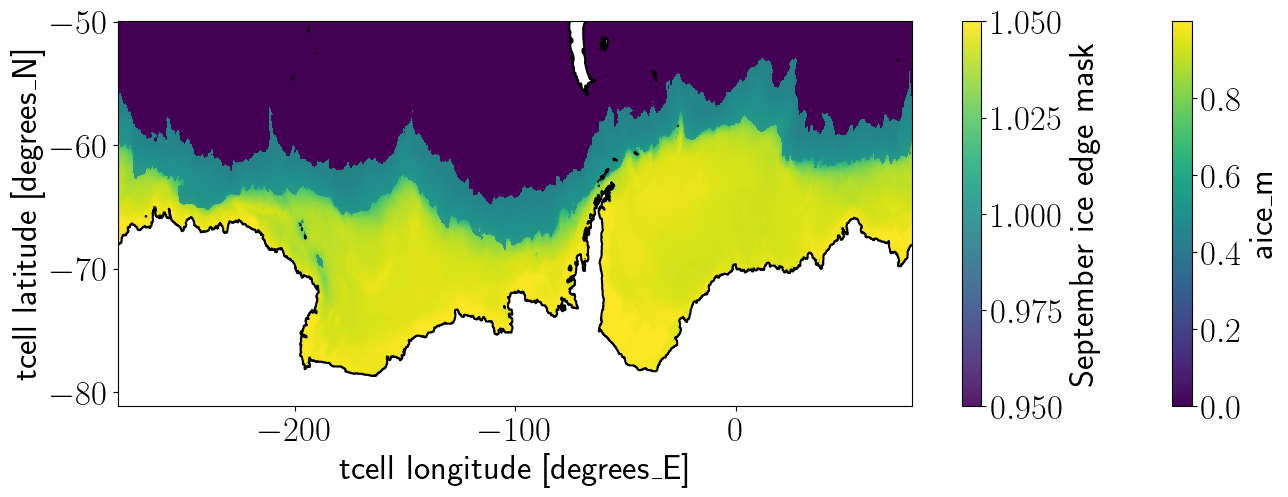

In [15]:
plt.figure(figsize=(16,5))
ICEf_Sep_mean.plot()
ICEf_Sep_mask.plot(alpha=0.9)
ht.plot.contour(levels=[0],colors='black')

MAsk used for the sea ice edge in september

In [16]:
ICEf_Sep_mask = ICEf_Sep_mask.drop(('TLON','TLAT','ULON','ULAT'))

In [17]:
EKE_Sep_t=EKE_Sep.interp(xu_ocean=xt_ocean,yu_ocean=yt_ocean.sel(yt_ocean=lat_slice))
EKE_Sep_t

<xarray.DataArray 'Eddy Kinectice energy at surface' (time: 23, yt_ocean: 666,
                                                      xt_ocean: 3600)> Size: 441MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan, 0.00448958, 0.0036558 , ..., 0.02258033,
         0.01547361, 0.01007079],
        [       nan, 0.00232938, 0.00188472, ..., 0.01635641,
         0.01031694, 0.00586921],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan, 0.10424403, 0.12826746, ..., 0.02355356,
         0.03231417, 0.05064482],
        [       nan, 0.09795434, 0.12912335, ..., 0.02566343,
         0.02945938, 0.04282774],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan, 0.00730502, 0.00825201, ..., 0.01514695,
         0.01208912, 0.00986592],
        [       nan, 0.00911211, 0.00999462, ..., 0.01305552,
         0.0113172 , 0.01039858],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) datetime64[ns] 184B 1996-09-16 1997-09-16 ... 2018-09-16
    xu_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    yu_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03

In [18]:
#caluculating the weighted average timeseries of these values
ICEf_Sep_MIZ_mean = (ICEf_Sep*ICEf_Sep_mask).weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).load()
ICEh_Sep_MIZ_mean = (ICEh_Sep*ICEf_Sep_mask).weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).load()
EKE_Sep_MIZ_mean = (EKE_Sep_t*ICEf_Sep_mask).weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).load()

Text(0, 0.5, 'Surface EKE [$m^{2}\\ s^{2}$]')

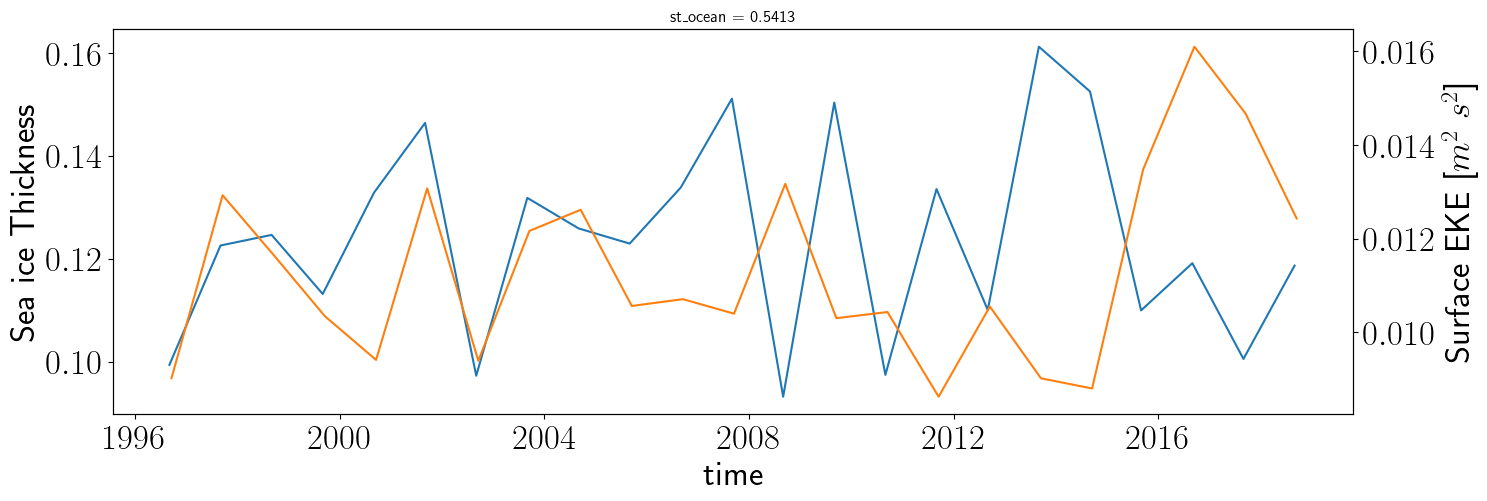

In [19]:
fig, ax1 = plt.subplots(figsize=(16,5))

ICEh_Sep_MIZ_mean.plot(ax=ax1,color='tab:blue',label='SIT')
plt.ylabel('Sea ice Thickness')
ax2 = ax1.twinx()
EKE_Sep_MIZ_mean.plot(ax=ax2,color='tab:orange',label='EKE')
plt.ylabel(r'Surface EKE [$m^{2}\ s^{2}$]')

In [20]:
time_slice1=slice('2013-01-01','2016-01-01')
time_slice2=slice('2016-01-01','2021-01-01')
#slicing regions for Sea ice fraction
ICEf_Sep_first = (ICEf_Sep*ICEf_Sep_mask).sel(time=time_slice1).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')
ICEf_Sep_last = (ICEf_Sep*ICEf_Sep_mask).sel(time=time_slice2).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')
#slicing regions for Sea ice thickness
ICEh_Sep_first = (ICEh_Sep*ICEf_Sep_mask).sel(time=time_slice1).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')
ICEh_Sep_last = (ICEh_Sep*ICEf_Sep_mask).sel(time=time_slice2).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')

#slicing regions for EKE
EKE_Sep_first = (EKE_Sep_t*ICEf_Sep_mask).sel(time=time_slice1).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')
EKE_Sep_last = (EKE_Sep_t*ICEf_Sep_mask).sel(time=time_slice2).mean('time').weighted(tarea.fillna(0)).mean('yt_ocean')

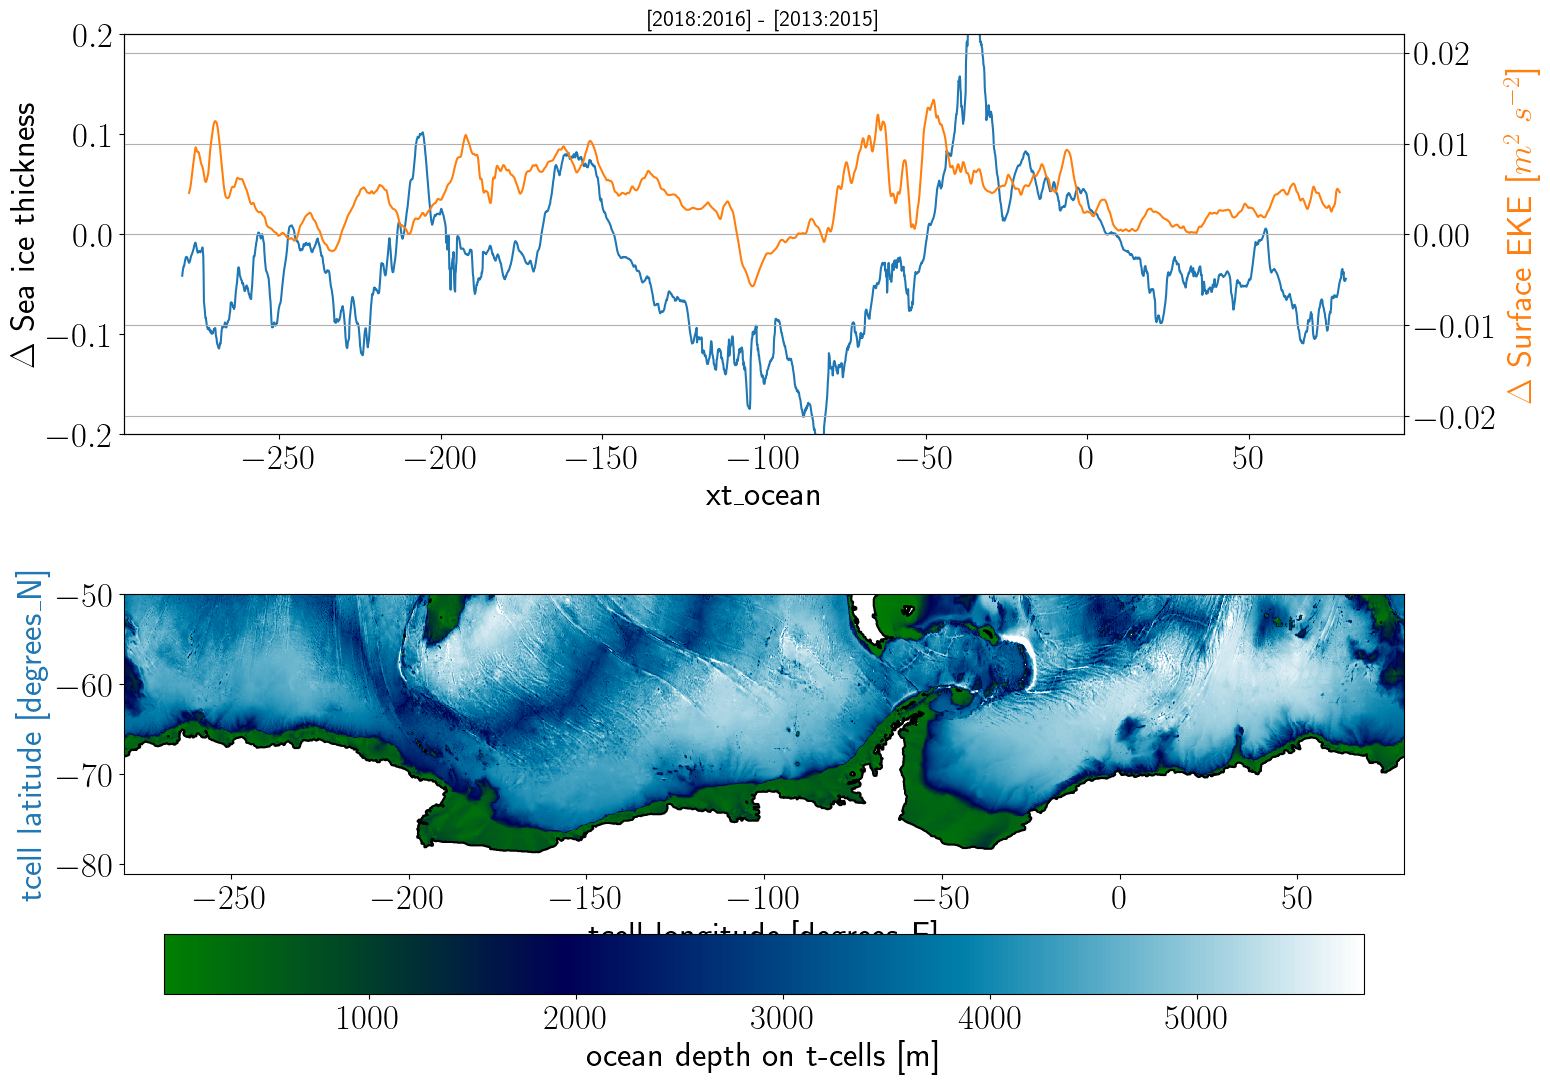

In [21]:
fig, ax1 = plt.subplots(2,1,figsize=(16,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


rw=40 #rolling mean window
norm_ice= .2 #norm for ice plotting
norm_EKE=.022 #norm for EKE plotting

(ICEh_Sep_last-ICEh_Sep_first).plot(ax=ax1[0],color='tab:blue',label='SIF')
plt.ylabel(r' $\Delta$ Sea ice Fraction',color='tab:blue');ax1[0].set_ylim(-norm_ice,norm_ice)
ax1[0].set_yticks([-.2,-.1,0,.1,.2])
plt.xlabel('Longitude'); ax1[0].set_ylabel(r'$\Delta$ Sea ice thickness')
ax2 = ax1[0].twinx()
(EKE_Sep_last-EKE_Sep_first).rolling(xt_ocean=rw,center=True).mean().plot(ax=ax2,color='tab:orange',label='EKE')
plt.ylabel(r'$\Delta$ Surface EKE [$m^{2}\ s^{-2}$]',color='tab:orange')
plt.grid();plt.ylim(-norm_EKE,norm_EKE)
plt.title('[2018:2016] - [2013:2015]',fontsize=16,fontweight='bold')
plt.xlabel('Longitude')

#subplot2

ht.sel(yt_ocean=lat_slice).where(ht>0).plot(ax=ax1[1],cmap='ocean',cbar_kwargs={"location": "bottom"})
ht.sel(yt_ocean=lat_slice).plot.contour(ax=ax1[1],levels=[0],colors='black')

In [22]:
%%time
level_ice=0.5
ICEf_02 = ICEf.where((ICEf<=level_ice) & (ICEf>0)).load()

ICEh_02 = ICEh.where((ICEf<=level_ice) & (ICEf>0)).load()

CPU times: user 1min, sys: 14 s, total: 1min 14s
Wall time: 1min 17s


In [23]:
#Target bins for SIC and SIT
target_bins=np.linspace(0,0.2,10)
target_bins4=np.linspace(0,0.5,10)
target_bins

# EKE in t points
EKE_t=EKE.interp(xu_ocean=xt_ocean,yu_ocean=yt_ocean.sel(yt_ocean=lat_slice)).load()

##off-shelf EKE in t points
EKE_inT = EKE.interp(xu_ocean=xt_ocean,yu_ocean=yt_ocean.sel(yt_ocean=lat_slice)).where(ht>1000).load()

ICEf_offshore = ICEf_02.where(ht>1000).isel(time=slice(0,-1)).load()
ICEh_offshore = ICEh_02.where(ht>1000).isel(time=slice(0,-1)).load()

EKE_inT['time']=ICEf_offshore.time

In [24]:
tarea.load()

<xarray.DataArray 'area_t' (yt_ocean: 666, xt_ocean: 3600)> Size: 10MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [50756284., 50756284., 50756284., ..., 50756284., 50756284.,
        50756284.],
       [50892436., 50892436., 50892436., ..., 50892436., 50892436.,
        50892436.],
       [51028820., 51028820., 51028820., ..., 51028820., 51028820.,
        51028820.]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [25]:
target_bins4

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])

In [26]:
ICEf_binned = histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (EKE_inT.fillna(0)*tarea).rename('EKE')) \
/histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (tarea).rename('EKE'))

ICEf_binned4 = histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins4], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (EKE_inT.fillna(0)*tarea).rename('EKE')) \
/histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins4], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (tarea).rename('EKE'))



ICEh_binned = histogram((ICEh_offshore).rename('SIT'), 
                          bins = [target_bins], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (EKE_inT.fillna(0)*tarea).rename('EKE')) \
/histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (tarea).rename('EKE'))

ICEh_binned4 = histogram((ICEh_offshore).rename('SIT'), 
                          bins = [target_bins4], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (EKE_inT.fillna(0)*tarea).rename('EKE')) \
/histogram((ICEf_offshore).rename('SIF'), 
                          bins = [target_bins4], 
                          dim = ['xt_ocean','yt_ocean'],
                          weights = (tarea).rename('EKE'))

In [27]:
timeind=9
ICEf_02 = (ICEf_offshore.groupby('time.month')[timeind]*ICEf_Sep_mask).weighted(tarea.fillna(0)).mean(('yt_ocean','xt_ocean'))
#ICEf_02 = ((ICEf_02.max() - ICEf_02 )/ICEf_02.max())*0.2 #normalized into a range between 0 and 0.2


ICEh_02 = (ICEh_offshore.groupby('time.month')[timeind]*ICEf_Sep_mask).weighted(tarea.fillna(0)).mean(('yt_ocean','xt_ocean'))
#ICEh_02 = ((ICEh_02.max() - ICEh_02 )/ICEh_02.max())


In [28]:
ICEf_binned4.name='mean EKE'

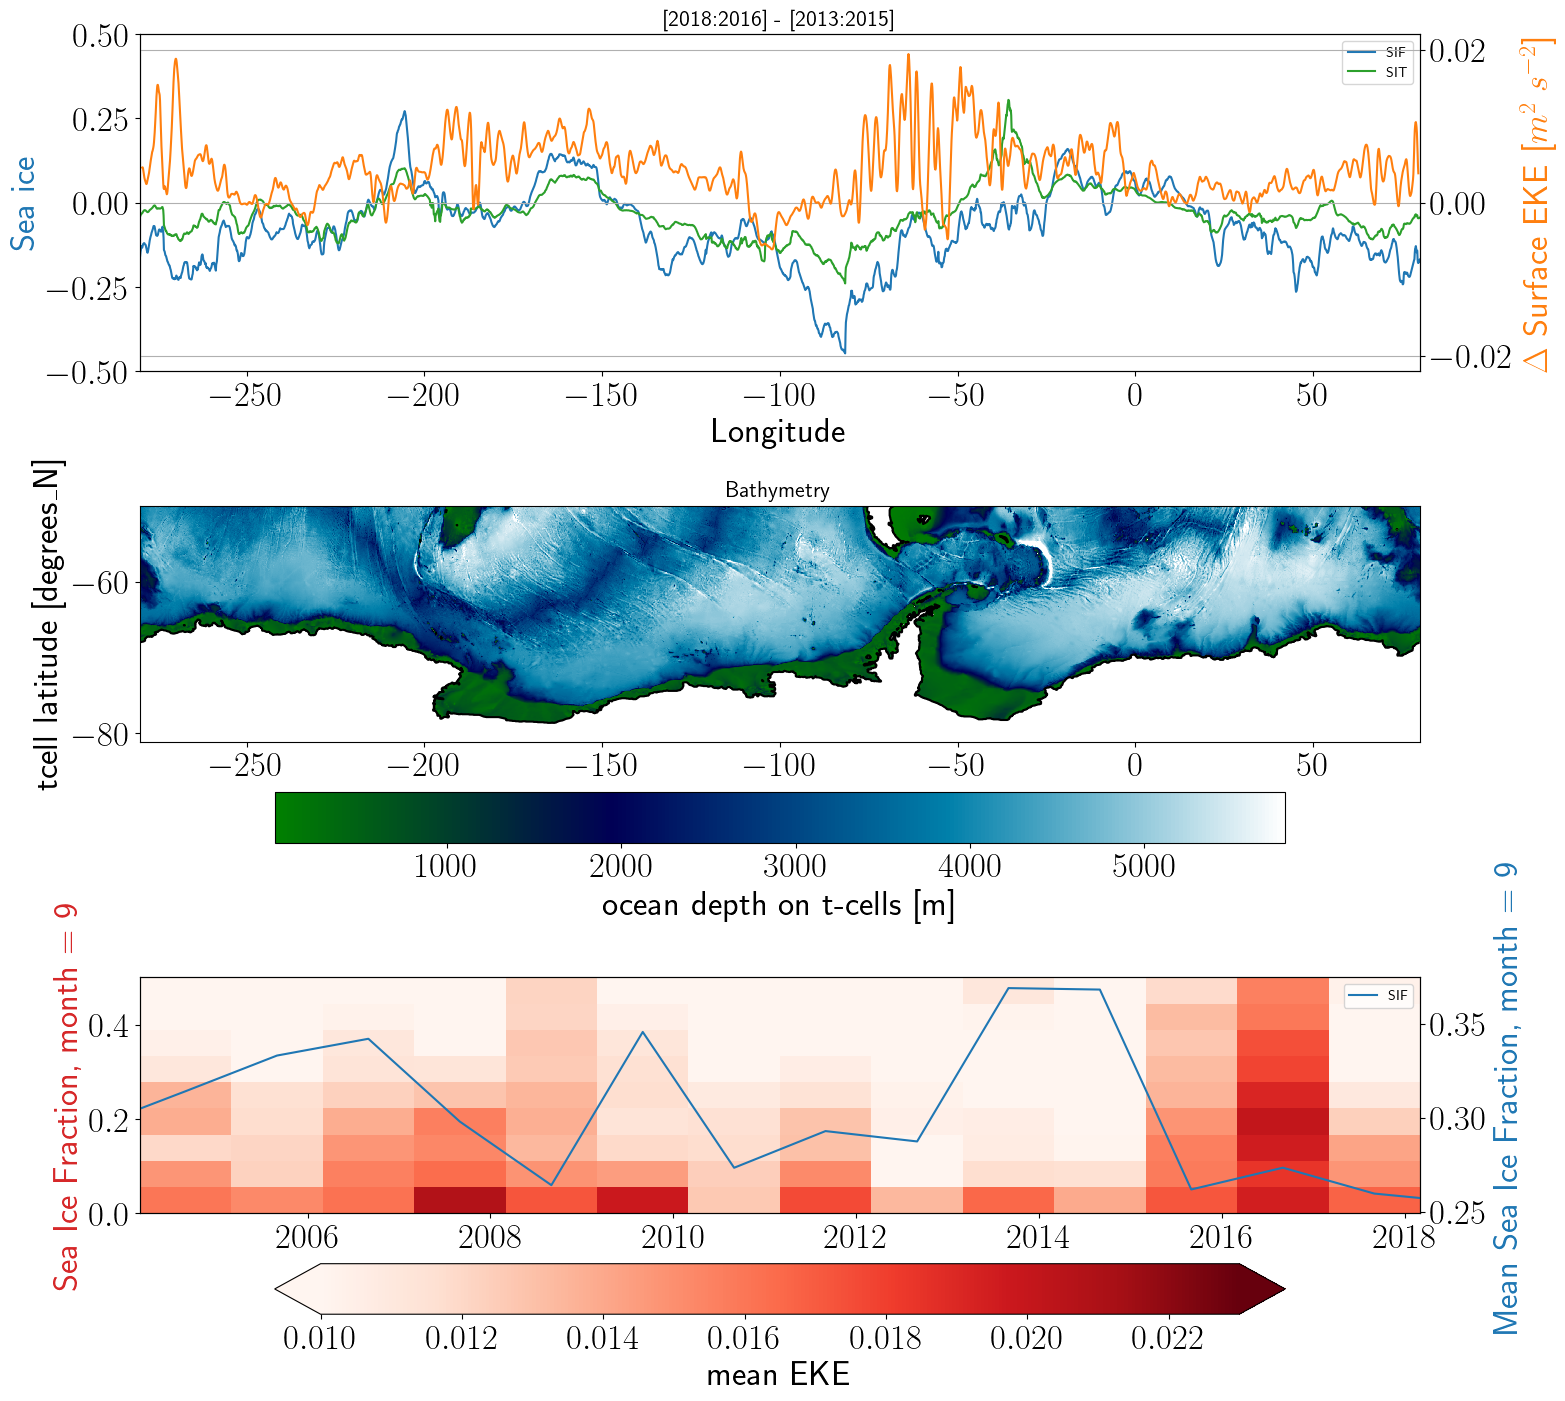

In [65]:
timeind=9



fig, ax1 = plt.subplots(3,1,figsize=(16,16))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


rw=10 #rolling mean window
norm_ice= .5 #norm for ice plotting
norm_EKE=.022 #norm for EKE plotting

(ICEf_Sep_last-ICEf_Sep_first).plot(ax=ax1[0],color='tab:blue',label='SIF')
(ICEh_Sep_last-ICEh_Sep_first).plot(ax=ax1[0],color='tab:green',label='SIT')
plt.ylabel(r' $\Delta$ Sea ice',color='tab:blue');ax1[0].set_ylim(-norm_ice,norm_ice)
plt.xlabel('Longitude'); ax1[0].legend(); #ax1[0].set_title('Sea Ice')
ax1[0].set_ylabel('Sea ice',color='tab:blue')
ax2 = ax1[0].twinx()
(EKE_Sep_last-EKE_Sep_first).rolling(xt_ocean=rw,center=True).mean().plot(ax=ax2,color='tab:orange',label='EKE')
plt.ylabel(r'$\Delta$ Surface EKE [$m^{2}\ s^{-2}$]',color='tab:orange')
plt.grid();ax2.set_ylim(-norm_EKE,norm_EKE)
plt.title('[2018:2016] - [2013:2015]',fontsize=16,fontweight='bold')
plt.xlabel('Longitude')
ax1[0].set_xlabel('Longitude')
ax1[0].set_xlim(-280,80)

#subplot2

ht.sel(yt_ocean=lat_slice).where(ht>0).plot(ax=ax1[1],cmap='ocean',cbar_kwargs={"location": "bottom"})
ht.sel(yt_ocean=lat_slice).plot.contour(ax=ax1[1],levels=[0],colors='black')
ax1[1].set_title('Bathymetry',fontsize=16); ax1[1].set_xlabel('')
ax22 = ax1[2].twinx()
#sunplot 3
ICEf_binned4.groupby('time.month')[timeind].isel(time=slice(-15,-1)).plot.pcolormesh(x='time',vmin=0.01,vmax=0.023,ax=ax1[2],\
                                                                                     extend='both',cmap='Reds',cbar_kwargs={"location": "bottom"})
plt.xlabel('Year'); ax1[2].set_ylabel('Sea Ice Fraction, month = ' + str(timeind),color='tab:red')
ICEf_Sep_MIZ_mean.plot(color='tab:blue',ax=ax22,label='SIF')
ax22.set_ylabel('Mean Sea Ice Fraction, month = ' + str(timeind),color='tab:blue')
#ICEh_Sep_MIZ_mean.plot(color='tab:green',ax=ax22,label='SIT')
ax1[2].set_ylim(0,0.5); ax22.legend(); ax1[2].set_xlabel('');


# Maps of SIC anomaly and EKE anomaly

In [30]:
timeind=9
Icefield_P1 = ICEf.groupby('time.month')[timeind].sel(time=time_slice1).mean('time').load() #period 1
Icefield_P2 = ICEf.groupby('time.month')[timeind].sel(time=time_slice2).mean('time').load() #period 2
Icefield_diff = Icefield_P2 - Icefield_P1

In [31]:
#EKE diff
EKE_P1 = EKE_inT.groupby('time.month')[timeind].sel(time=time_slice1).mean('time').load() #period 1
EKE_P2 = EKE_inT.groupby('time.month')[timeind].sel(time=time_slice2).mean('time').load() #period 2
EKE_diff = EKE_P2 - EKE_P1

In [32]:
EKE_diff

<xarray.DataArray 'Eddy Kinectice energy at surface' (yt_ocean: 666,
                                                      xt_ocean: 3600)> Size: 19MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan, -0.00197739,  0.01388135, ..., -0.0343563 ,
        -0.03460453, -0.02899199],
       [        nan, -0.00599863,  0.01006479, ..., -0.03838914,
        -0.03840148, -0.03324392],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03
    st_ocean  float64 8B 0.5413
    xu_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    yu_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03

Text(0.5, 1.0, '[2018:2016] - [2015:2013]')

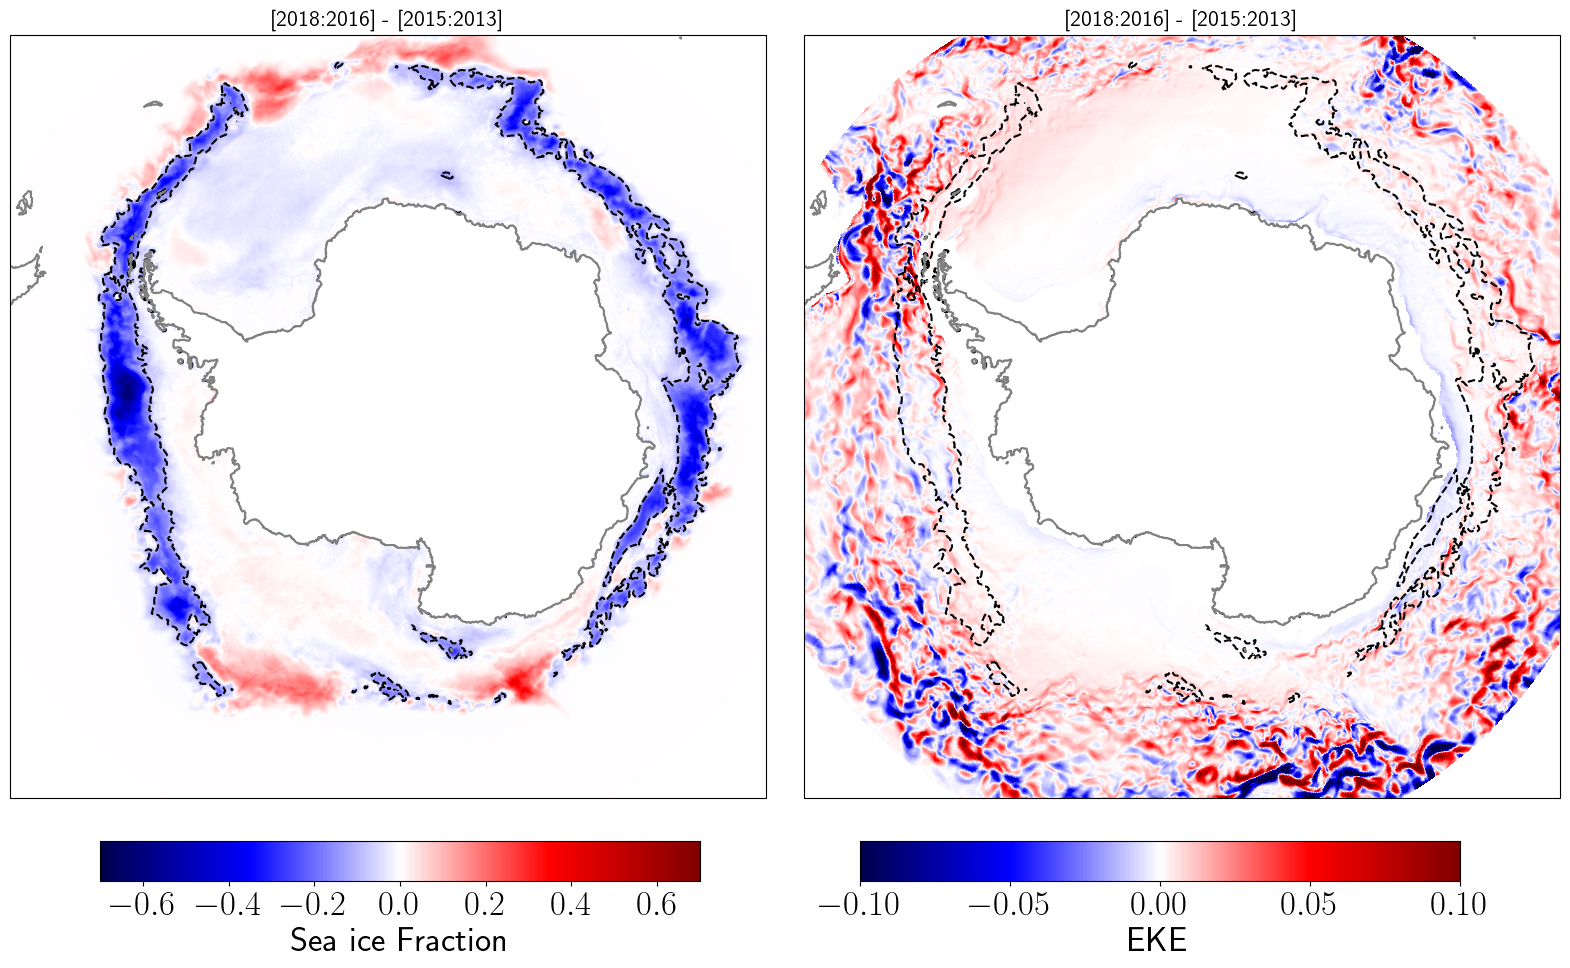

In [33]:
projection = ccrs.SouthPolarStereo()

fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [2, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())


#ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())

plt_icefrac = Icefield_diff.plot.pcolormesh(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    extend="both",vmin=-.7,vmax=.7,
    cmap='seismic',ax=ax,add_colorbar=False)

Icefield_diff.plot.contour(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    levels=[-0.1,],
    colors='black',linestyle=':',ax=ax,add_colorbar=False)

ht.plot.contour(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    levels=[0,],
    colors='grey',ax=ax,add_colorbar=False)

cax = fig.add_axes([0.17, 0.03, 0.3, 0.04])
cbar = plt.colorbar(plt_icefrac, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [-.6,-.4,-.2,0,.2,.4,.6])
cbar.set_label(r'Sea ice Fraction', fontsize = 25)

ax.set_title('[2018:2016] - [2015:2013]',fontsize=16)


# subplt 2
ax1.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
plt_eke = EKE_diff.plot.pcolormesh(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    extend="both",vmin=-.1,vmax=.1,
    cmap='seismic',ax=ax1,add_colorbar=False)

Icefield_diff.plot.contour(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    levels=[-0.1,],
    colors='black',linestyle=':',ax=ax1,add_colorbar=False)

ht.plot.contour(x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    levels=[0,],
    colors='grey',ax=ax1,add_colorbar=False)

cax2 = fig.add_axes([0.55, 0.03, 0.3, 0.04])
cbar2 = plt.colorbar(plt_eke, cax=cax2, orientation='horizontal', shrink = 0.5, ticks = [-.1,-.05,0,.05,.1])
cbar2.set_label(r'EKE', fontsize = 25)

ax1.set_title('[2018:2016] - [2015:2013]',fontsize=16)

In [58]:
Sea ice fraction and EKE anomalies between the two previous periods of high and low sea ice shown above in a projection view

SyntaxError: invalid syntax (3532047780.py, line 1)

Text(0.5, 1.0, '[2018:2016] - [2015:2013]')

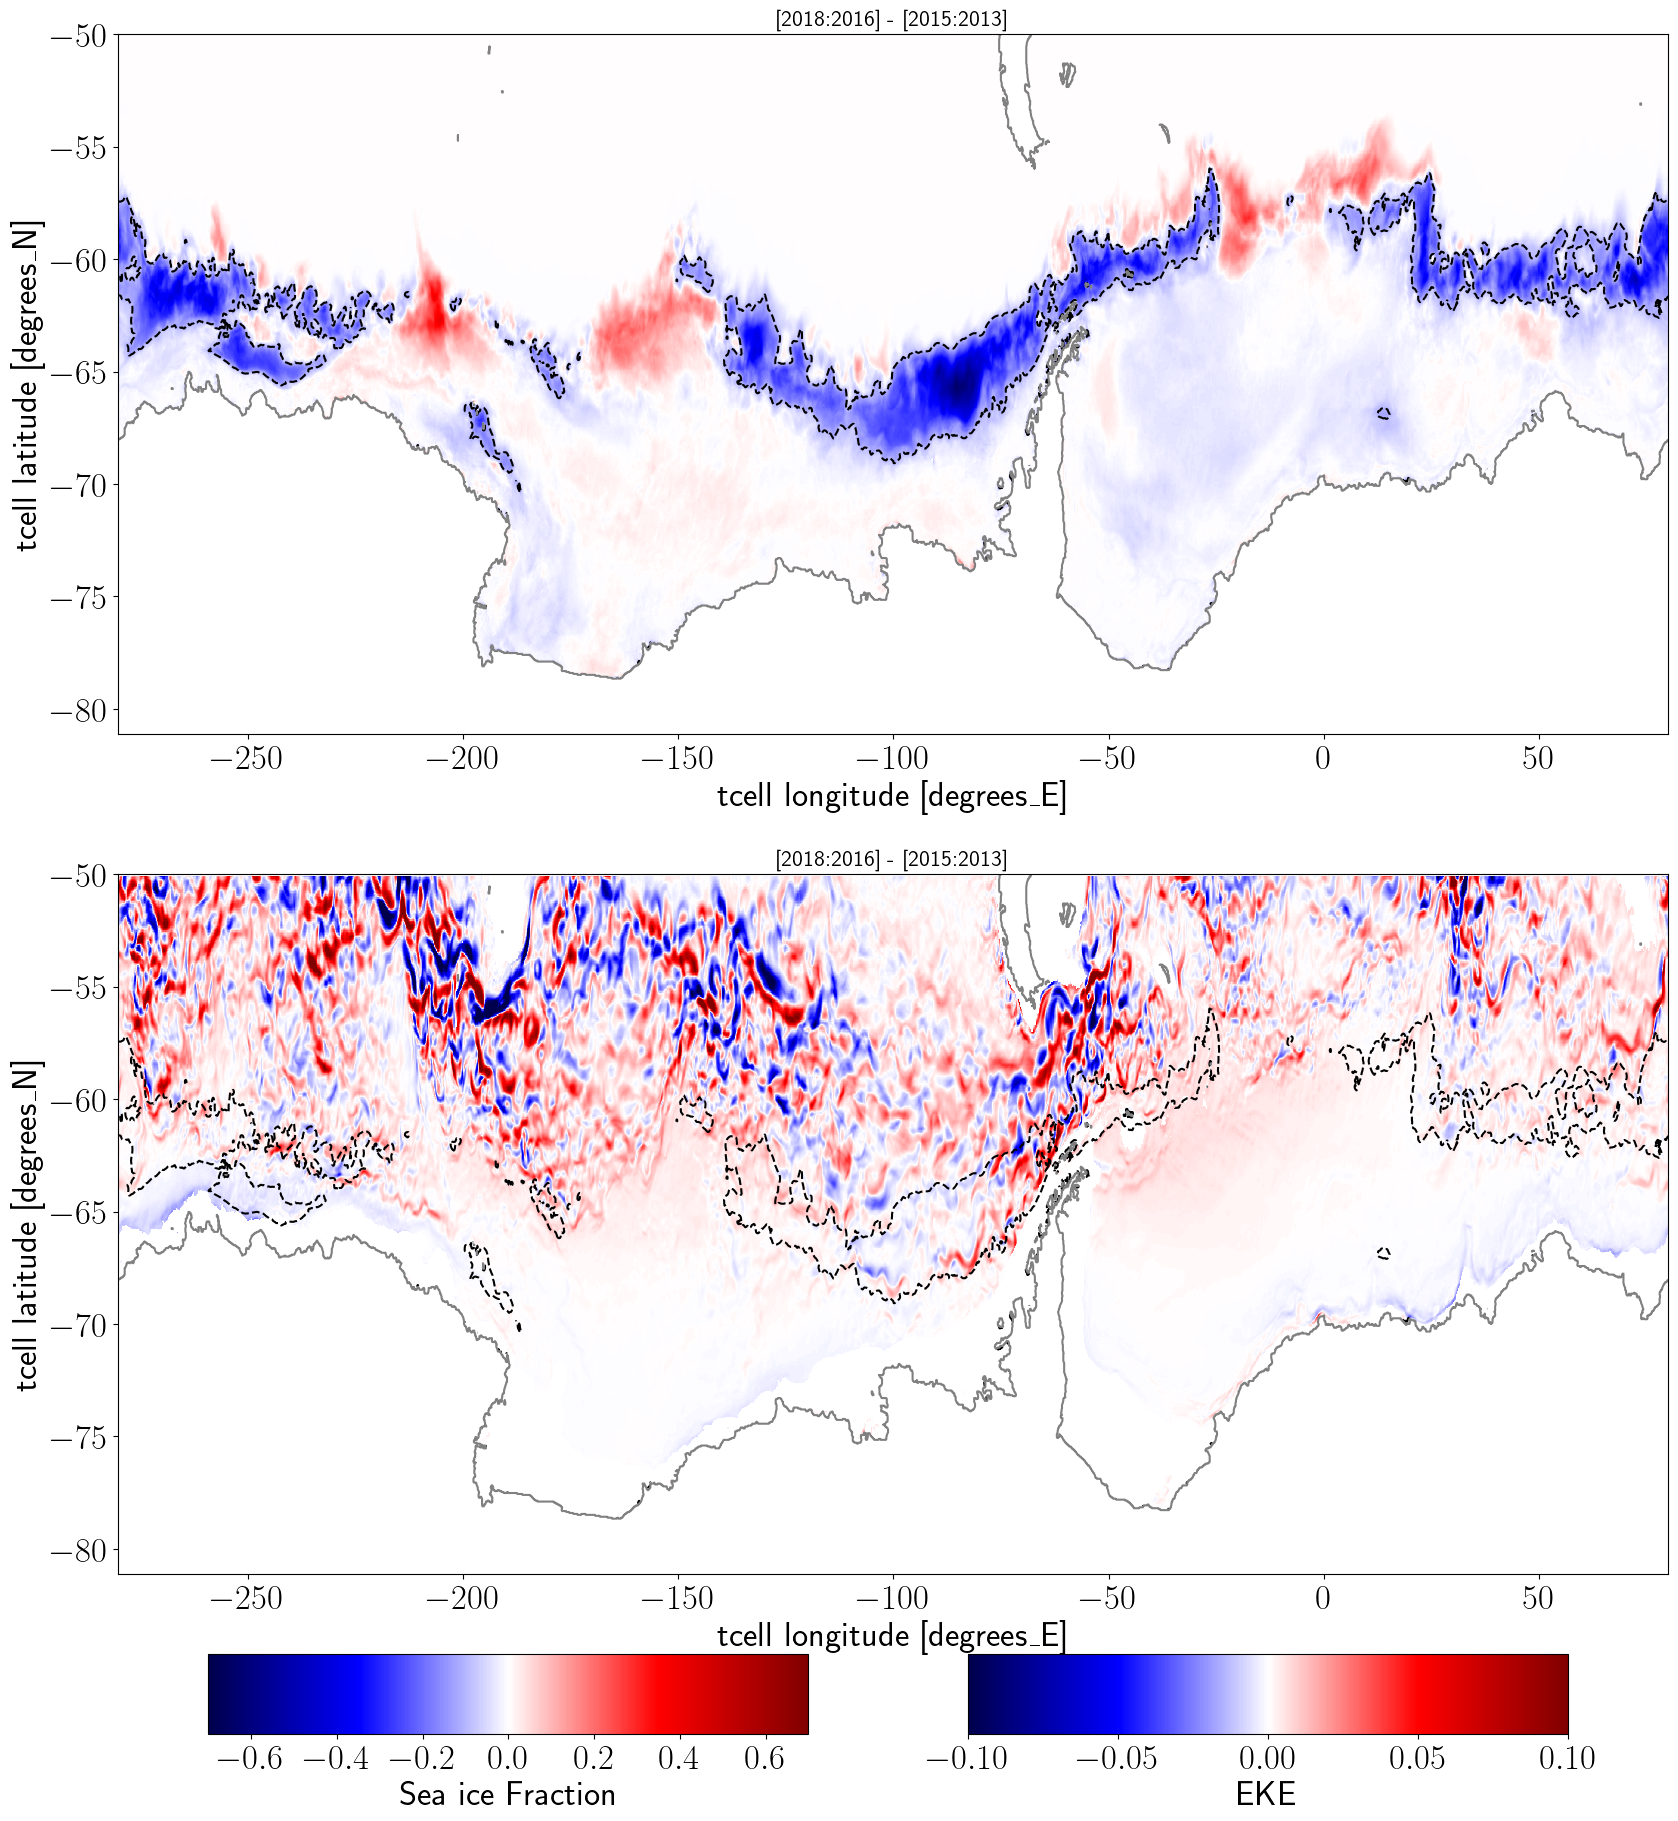

In [34]:
projection = ccrs.SouthPolarStereo()

fig  = plt.figure(1, figsize = (20, 20))
gs = gridspec.GridSpec(2,1, height_ratios = [2, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])


#ax = plt.axes(projection=projection)

plt_icefrac = Icefield_diff.plot.pcolormesh(x="xt_ocean",
    y="yt_ocean",
    extend="both",vmin=-.7,vmax=.7,
    cmap='seismic',ax=ax,add_colorbar=False)

Icefield_diff.plot.contour(x="xt_ocean",
    y="yt_ocean",
    levels=[-0.1,],
    colors='black',linestyle=':',ax=ax,add_colorbar=False)

ht.plot.contour(x="xt_ocean",
    y="yt_ocean",
    levels=[0,],
    colors='grey',ax=ax,add_colorbar=False)

cax = fig.add_axes([0.17, 0.03, 0.3, 0.04])
cbar = plt.colorbar(plt_icefrac, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [-.6,-.4,-.2,0,.2,.4,.6])
cbar.set_label(r'Sea ice Fraction', fontsize = 25)

ax.set_title('[2018:2016] - [2015:2013]',fontsize=16)


# subplt 2
plt_eke = EKE_diff.plot.pcolormesh(x="xt_ocean",
    y="yt_ocean",
    extend="both",vmin=-.1,vmax=.1,
    cmap='seismic',ax=ax1,add_colorbar=False)

Icefield_diff.plot.contour(x="xt_ocean",
    y="yt_ocean",
    levels=[-0.1,],
    colors='black',linestyle=':',ax=ax1,add_colorbar=False)

ht.plot.contour(x="xt_ocean",
    y="yt_ocean",
    levels=[0,],
    colors='grey',ax=ax1,add_colorbar=False)

cax2 = fig.add_axes([0.55, 0.03, 0.3, 0.04])
cbar2 = plt.colorbar(plt_eke, cax=cax2, orientation='horizontal', shrink = 0.5, ticks = [-.1,-.05,0,.05,.1])
cbar2.set_label(r'EKE', fontsize = 25)

ax1.set_title('[2018:2016] - [2015:2013]',fontsize=16)

Sea ice fraction and EKE anomalies between the two previous periods of high and low sea ice shown above in a no-projection view

# Hovmuller of EKE, T and SIC, on the ice edge region, for a depth range of 300m. 

Inpsired by Gupta's paper

In [35]:
depth_slice_surf=slice(0,300)
U_surf  = cc.querying.getvar(exp, 'u', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yu_ocean=lat_slice).sel(st_ocean=depth_slice_surf)

V_surf  = cc.querying.getvar(exp, 'v', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yu_ocean=lat_slice).sel(st_ocean=depth_slice_surf)

In [36]:
T_surf  = cc.querying.getvar(exp, 'temp', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yt_ocean=lat_slice).sel(st_ocean=depth_slice_surf) -273.15

In [37]:
EKE_surf=1/2*((U_surf**2)+(V_surf**2))
EKE_surf.name='Eddy Kinectice energy at surface'
EKE_surf

<xarray.DataArray 'Eddy Kinectice energy at surface' (time: 276, st_ocean: 34,
                                                      yu_ocean: 665,
                                                      xu_ocean: 3600)> Size: 90GB
dask.array<mul, shape=(276, 34, 665, 3600), dtype=float32, chunksize=(3, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 5kB -81.09 -81.05 -81.0 ... -50.12 -50.06
  * st_ocean  (st_ocean) float64 272B 0.5413 1.681 2.94 ... 229.3 254.4 282.0
  * time      (time) datetime64[ns] 2kB 1996-01-16T12:00:00 ... 2018-12-16T12...

In [38]:
#Extracting september 
EKE_surf_Sep= EKE_surf.groupby('time.month')[timeind].interp(xu_ocean=xt_ocean,yu_ocean=yt_ocean.sel(yt_ocean=lat_slice)) * ICEf_Sep_mask
T_surf_Sep = T_surf.groupby('time.month')[timeind] * ICEf_Sep_mask

T_surf_Sep

<xarray.DataArray (time: 23, st_ocean: 34, yt_ocean: 666, xt_ocean: 3600)> Size: 7GB
dask.array<mul, shape=(23, 34, 666, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -50.09 -50.03
  * st_ocean  (st_ocean) float64 272B 0.5413 1.681 2.94 ... 229.3 254.4 282.0
  * time      (time) datetime64[ns] 184B 1996-09-16 1997-09-16 ... 2018-09-16

In [39]:
#calcualting the mean over the periods for the hovmoller
EKE_surf_Sep_mean=EKE_surf_Sep.weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).load()
T_surf_Sep_mean=T_surf_Sep.weighted(tarea.fillna(0)).mean(('xt_ocean','yt_ocean')).load()

In [40]:
EKE_surf_Sep_ano = EKE_surf_Sep_mean - EKE_surf_Sep_mean.mean('time')
EKE_surf_Sep_ano.name = 'EKE anomaly'

T_surf_Sep_ano = T_surf_Sep_mean - T_surf_Sep_mean.mean('time')
T_surf_Sep_ano.name = 'Temperature anomaly'

In [41]:
sigma0  = cc.querying.getvar(exp, 'pot_rho_0', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})\
.sel(time=time_slice,yt_ocean=lat_slice).sel(st_ocean=depth_slice_surf)

sigma0_Sep = sigma0.groupby('time.month')[timeind] * ICEf_Sep_mask
sigma0_Sep_mean_P1 = sigma0_Sep.weighted(tarea.fillna(0)).mean('xt_ocean').sel(time=time_slice1).mean('time').load()
sigma0_Sep_mean_P2 = sigma0_Sep.weighted(tarea.fillna(0)).mean('xt_ocean').sel(time=time_slice2).mean('time').load()

sigma0_Sep_ano = sigma0_Sep_mean_P2- sigma0_Sep_mean_P1

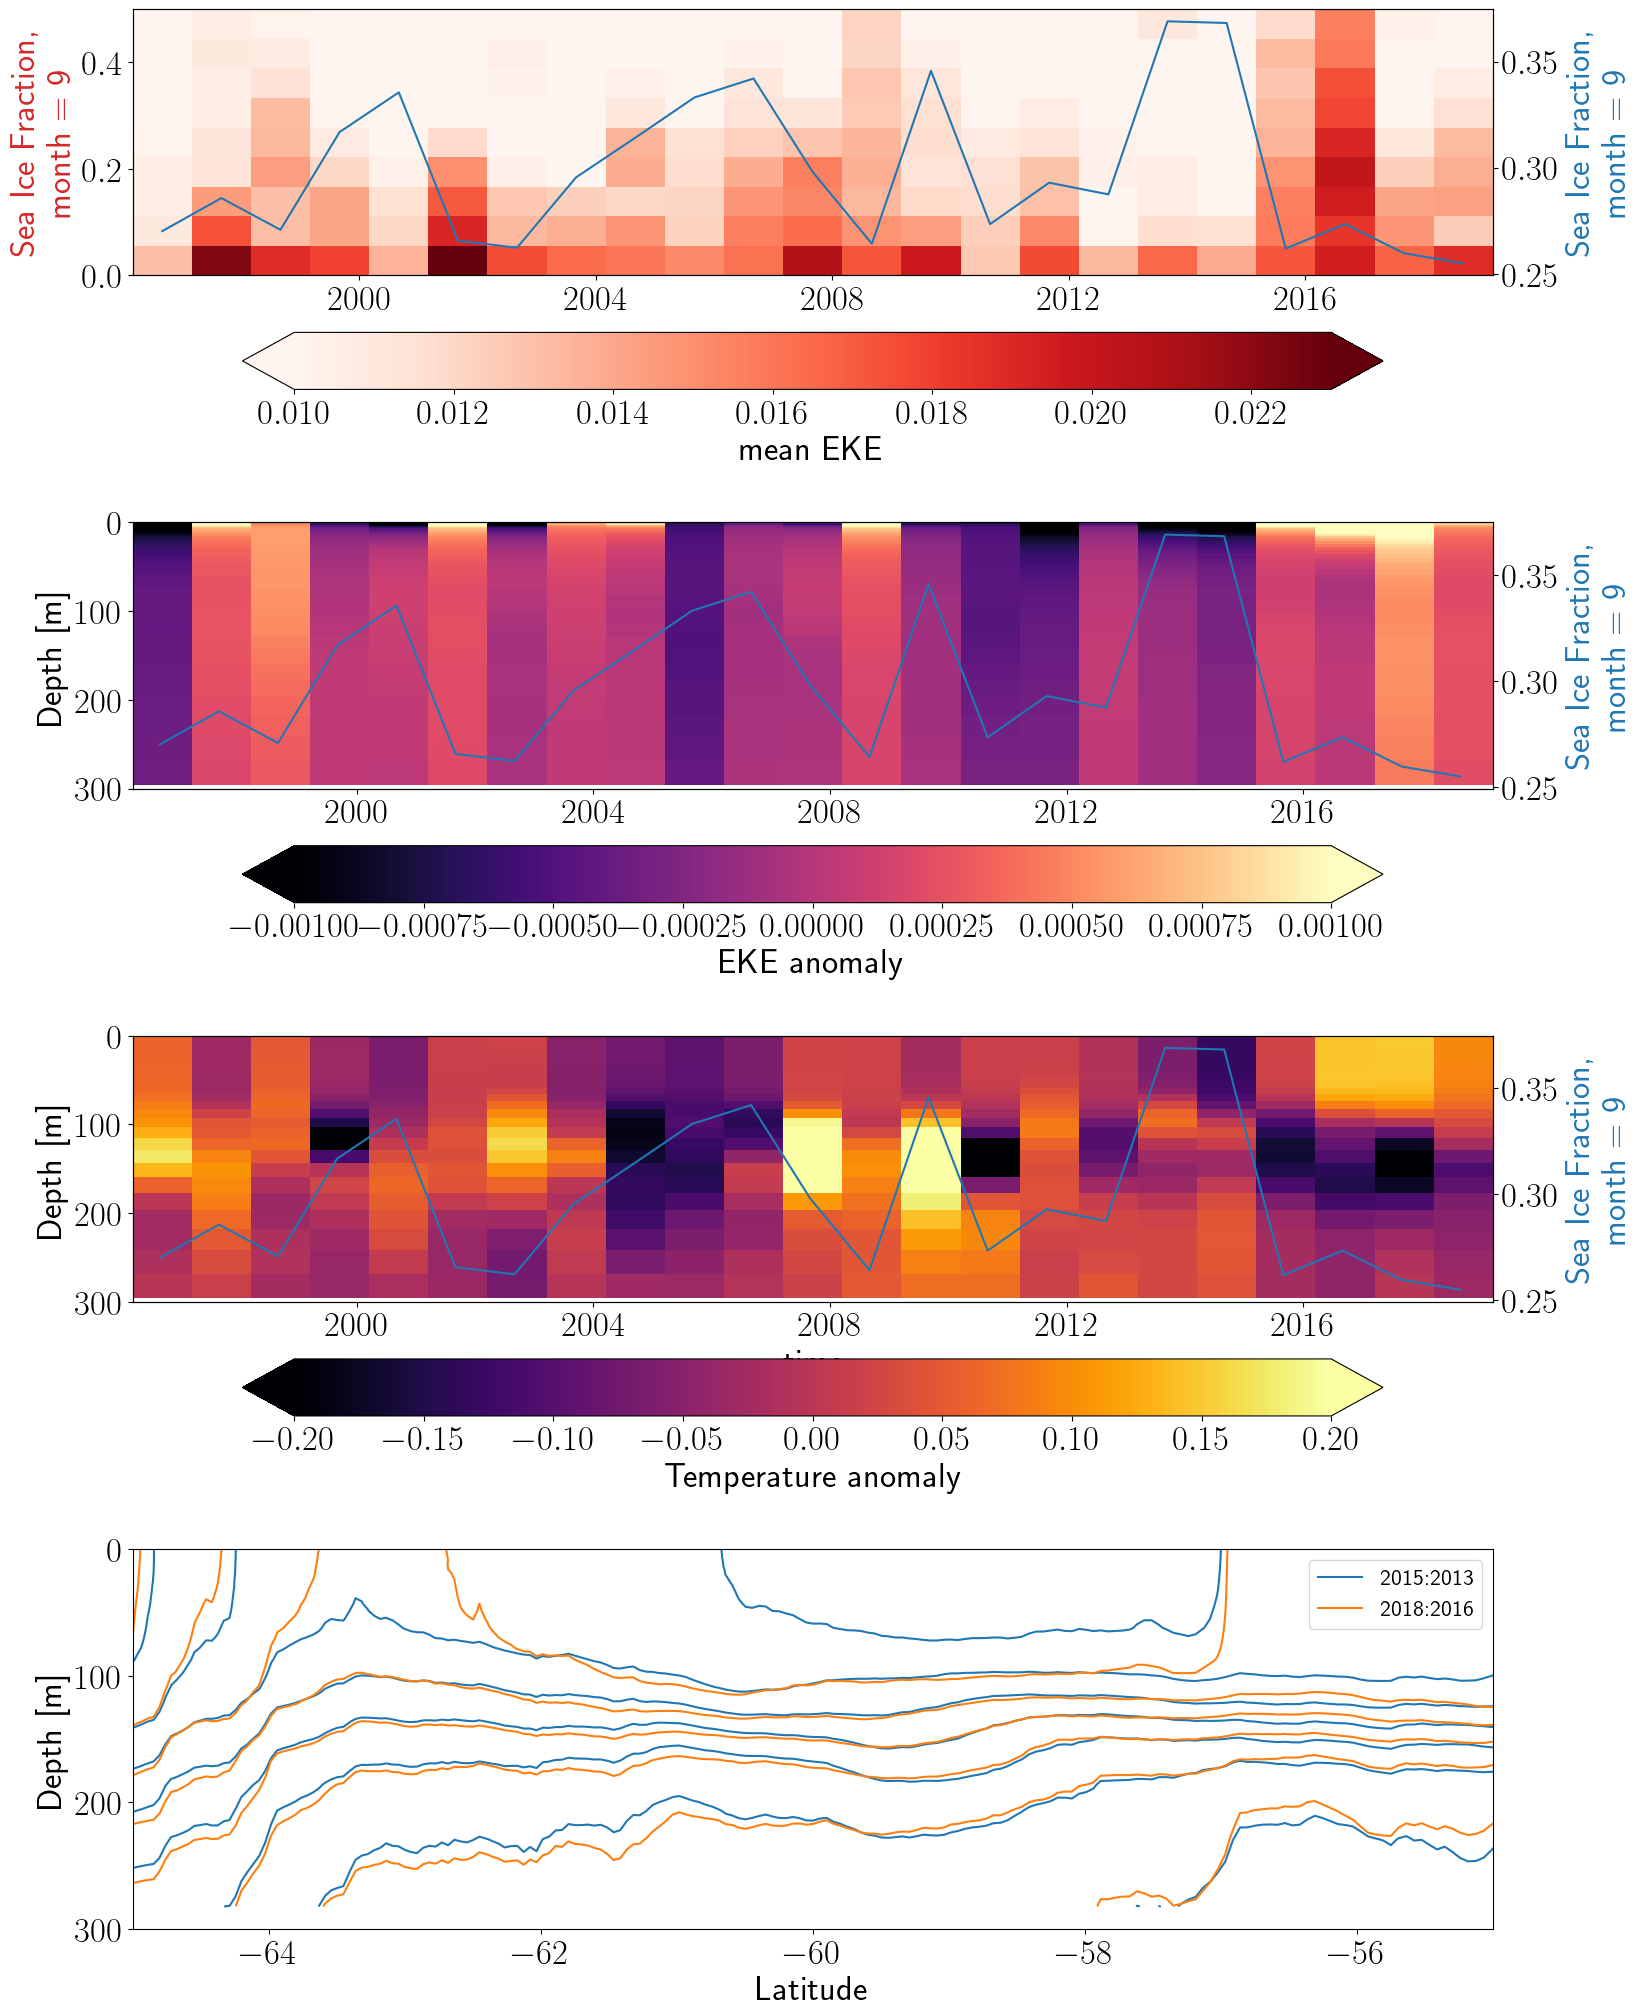

In [68]:
timeind=9

fig, ax1 = plt.subplots(4,1,figsize=(17,24))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)

#Subplot 1
ax22 = ax1[0].twinx()
#sunplot 3
ICEf_binned4.groupby('time.month')[timeind].plot.pcolormesh(x='time',vmin=0.01,vmax=0.023,ax=ax1[0],\
                                                                                     extend='both',cmap='Reds',cbar_kwargs={"location": "bottom"})
plt.xlabel('Year'); ax1[2].set_ylabel('Sea Ice Fraction, month = ' + str(timeind),color='tab:red')
ICEf_Sep_MIZ_mean.plot(color='tab:blue',ax=ax22,label='SIF')
ax22.set_ylabel('Sea Ice Fraction, \n month = ' + str(timeind),color='tab:blue')
ax1[0].set_ylabel('Sea Ice Fraction, \n month = ' + str(timeind),color='tab:red')
ax1[0].set_xlabel('')


#subplot 2
ax23 = ax1[1].twinx()
EKE_surf_Sep_ano.plot.pcolormesh(y='st_ocean',ax=ax1[1],vmin=-0.001,vmax=0.001,extend='both',cmap='magma',cbar_kwargs={"location": "bottom"})
ICEf_Sep_MIZ_mean.plot(color='tab:blue',ax=ax23,label='SIF')
ax23.set_ylabel('Sea Ice Fraction, \n month = ' + str(timeind),color='tab:blue')
ax1[1].set_ylim(300,0); ax1[1].set_xlabel('')
ax1[1].set_ylabel('Depth [m]')

#subplot 3
ax24 = ax1[2].twinx()
T_surf_Sep_ano.plot.pcolormesh(y='st_ocean',ax=ax1[2],extend='both',vmin=-0.2,vmax=0.2,cmap='inferno',cbar_kwargs={"location": "bottom"})
ICEf_Sep_MIZ_mean.plot(color='tab:blue',ax=ax24,label='SIF')
ax24.set_ylabel('Sea Ice Fraction, \n month = ' + str(timeind),color='tab:blue')
ax1[2].set_ylim(300,0)
ax1[2].set_ylabel('Depth [m]', color='black')

#subplot 4
sigma0_Sep_mean_P1.plot.contour(levels=np.linspace(1027.2,1027.8,10),colors='tab:blue',ax=ax1[3])
sigma0_Sep_mean_P2.plot.contour(levels=np.linspace(1027.2,1027.8,10),colors='tab:orange',ax=ax1[3])
ax1[3].plot([-1,-1],[0,0],color='tab:blue',label='2015:2013')
ax1[3].plot([-1,-1],[0,0],color='tab:orange',label='2018:2016')
ax1[3].set_xlim(-65,-55); ax1[3].set_ylim(300,0)
ax1[3].set_ylabel('Depth [m]')
ax1[3].set_xlabel('Latitude')
ax1[3].legend(fontsize=16)

The plt above shows a few things. The top contourf shows the timeseries of surface mean Eddy kinectic energy, binned into Sea ice fraction bins, for the regions between the shelf and the sea ice edge.  The blue line is the mean sea ice fraction in the September ice margin zone ( defined as the region between the minimum monthly historical september extension and maximum monthly historical september extension).



In that first plot we can see that in 2015 and 2016 ( and previous low september years) we have an increase in the penetration of eddies into the sea ice, getting reasonably high EKE to regions of up to 0.4 in sea ice fraction.



The second plot shows the structure of the EKE in september during these years and we can see that the eddy activity in these years are concentrated at the surface



The third plot is the september temperature anomaly, and we can see some warm anomalies in the surface in the 2016:2018 period, where we have increased EKE. These results suggests that an increased Eddy activity in the Southern Ocean could be bringing heat to below the sea ice, and perhaps melting it. 


The last plot is to test an hypotehsis that an increase isopycnal slope in the Southern Ocean could have increased the Eddy activity. We plotted the zonal mean isopycnals structure between [2017:2018] in orange and [2013:2016] in blue. A bigger slope is perhaps seen in the later period, that could drive the increasing eddy activity in the Southern Ocean.

